In [1]:
import NBHD
import dataset_utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim

from pytorch_metric_learning import distances, losses, miners, reducers

torch.set_printoptions(profile="full")

def get_Cosine_margin(model, x_test, y_test=None):
    def cosine_distance(a, b):
        return 1 - torch.cosine_similarity(a[:, np.newaxis, :], b, dim=-1)
    
    # Compute test samples' Hamming distance
    class_hvs = model.class_hvs.data
    test_enc_hvs = model.encoding(x_test)
    test_Cosine_dist = cosine_distance(test_enc_hvs, class_hvs)

    sorted_test_Cosine_distance, _ = torch.sort(test_Cosine_dist, dim=-1, descending=False)
    test_enc_hvs_Cosine_margin = (sorted_test_Cosine_distance[:,1:]-sorted_test_Cosine_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
    mean_test_Cosine_margin = torch.mean(test_enc_hvs_Cosine_margin).item()

    return mean_test_Cosine_margin

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# # Compute mean Hamming distance between class HVS
	class_hvs = model.quantize_class_hvs(model.class_hvs.data, soft = False)
	# class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	# mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = model.encoding(x_test, soft = False)
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	return mean_test_Hamming_margin

def HD_test(model, x_test, y_test):
    out = model(x_test, embedding=False)
    preds = torch.argmax(out, dim=-1)

    acc = torch.mean((preds==y_test).float())	
    return acc

def visualize(model, test_loader, nClasses, device="cuda"):
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        out = model(data, embedding=False)
        for label in range(nClasses):
            res = out[labels == label].cpu().detach()
            sns.heatmap(res)
            plt.title("label: {}".format(label))
            plt.show()
        break

def plot_quant(model, x_test, label):
        x = torch.linspace( model.quantize_data.weights[0].item() - 5, model.quantize_data.weights[len(model.quantize_data.weights) - 1].item() + 5 , 1000)
        y1 = model.quantize_data(x, soft = False)
        y2 = model.quantize_data(x, soft = True).detach()
        
        plt.plot(x, y1, c="red", label = "Hard Quantization")
        plt.plot(x, y2, c="blue", label = "Soft Quantization")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Quantize function over learning operations. Levels: {}, Iteration:{}".format(levels, label))
        plt.legend()
        plt.show()

        sns.displot(model.class_hv_distribution.cpu().flatten().detach())
        for weight in model.quantize_class_hvs.weights.detach():
            plt.axvline(weight, ls="--", c = "red")
        plt.title("non-quantized class_hvs distribution")
        plt.show()
        sns.displot(model.class_hvs.cpu().flatten().detach())
        plt.title("quantized class_hvs distribution")
        plt.show()
        
        

        y3 = model.encoding(x_test, quantize=False).cpu().flatten().detach()
        y4 = model.quantize_data(y3, soft = False).cpu()
        sns.displot(y3)
        plt.title("encoding distribution")
        for weight in model.quantize_data.weights.detach():
            plt.axvline(weight, ls="--", c = "red")
        plt.show()
        sns.displot(y4)
        plt.title("encoding quantization distribution")
        plt.show()
        for name, param in model.named_parameters():
            if("quant" in name):
                print(name, param.data)

def test_quantizer(dataset, D = 1000, levels = 3, m=10, HD_lr = 0.05, quant_lr=1.0, t=0.7, metric_lr = 0.01,  enc_type='RP', similarity_type = "cosine", plot=False, visualize=False):
    nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset(dataset, 256, "cuda")
    model = NBHD.HDC(dim = nFeatures, D=D, num_classes=nClasses, m=m, levels=levels, enc_type=enc_type, similarity_type= similarity_type)

    model.init_quantize(x_train)
    device = "cuda"

    accuracies = []
    margins = []

    num_metric_epochs = 10
    model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
    optimizer = optim.Adam(model.parameters(), lr=metric_lr)
    distance = distances.CosineSimilarity()

    reducer = reducers.ThresholdReducer(low=0.0)
    loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
    mining_func = miners.TripletMarginMiner(
        margin=0.2, distance=distance, type_of_triplets="semihard", )

    ### pytorch-metric-learning stuff ###
    for epoch_i in range(1, num_metric_epochs + 1):
        NBHD.metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch_i)
        # accuracies.append(HD_test(model, x_test, y_test).item())
        # margins.append(get_Cosine_margin(model, x_test, y_test))
        # for name, param in model.named_parameters():
        #     if("quant" in name):
        #         print(name, param.data)

    if plot:
        plot_quant(model, x_test, "0")
    if visualize:
        visualize(model, test_loader, nClasses)

    model.init_class(x_train, y_train)
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Cosine_margin(model, x_test, y_test))

    num_HD_epoch = 0

    for epoch_i in range(1, num_HD_epoch+1):
        model.HD_train_step(x_train, y_train, lr=HD_lr)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))

    num_quant_epochs = 20

    optimizer = optim.SGD(model.parameters() , quant_lr)

    def cosineLoss(embeddings, labels, t=t):
        similarities = model.similarity(model.class_hvs, embeddings)
        a = (1 - similarities[torch.arange(similarities.size(0)), labels]).abs().mean() #

        similarities[torch.arange(similarities.size(0)), labels] = 0
        b = similarities.abs().mean() #
        return t * a + (1-t) * b

    quant_loss = cosineLoss
    for epoch_i in range(1, num_quant_epochs + 1):
        NBHD.quant_train(model, quant_loss, device, train_loader, optimizer, epoch_i)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))





    num_mixed_epoch = 0
    for epoch_i in range(1, num_mixed_epoch + 1):
        model.HD_train_step(x_train, y_train, lr=HD_lr)
        NBHD.quant_train(model, quant_loss, device, train_loader, optimizer, epoch_i)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))

    
    plt.plot(accuracies, label="Accuracy", c = "blue")
    plt.plot(margins, label="Margins", c="cyan")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    # plt.axvline(x=10, c= "red" , ls="--")
    plt.title("Accuracy of {} Levels, {} Dimensions, Dataset:{}".format(levels, D, dataset))
    plt.legend()
    plt.show()
    print("Maximum Accuracy:{}".format(max(accuracies)))
    
    # print("class hv equality: ", torch.equal(before, model.class_hvs) )

    if plot:
            plot_quant(model, x_test, "end")
    if visualize:
        visualize(model, test_loader, nClasses)
    print('Level:',level," Metric_lr:",metric_lr, " Accuracies:" ,accuracies, "Margins:", margins, "t:" , t)
    return accuracies, margins

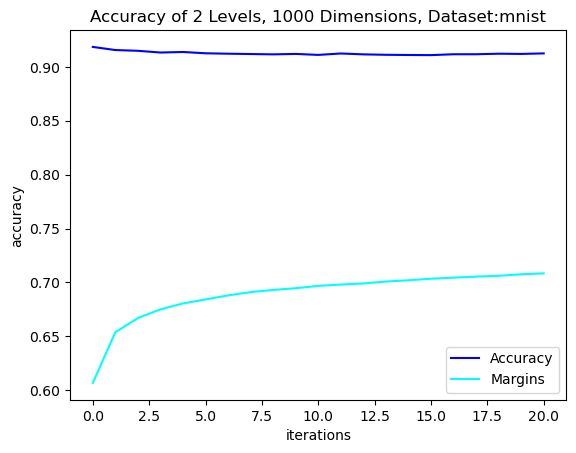

Maximum Accuracy:0.9185000061988831
Level: 2  Metric_lr: 0.001  Accuracies: [0.9185000061988831, 0.9156000018119812, 0.914900004863739, 0.9132999777793884, 0.9138000011444092, 0.9125999808311462, 0.9121999740600586, 0.911899983882904, 0.9115999937057495, 0.9120000004768372, 0.9110999703407288, 0.91239994764328, 0.9115999937057495, 0.9111999869346619, 0.9109999537467957, 0.9108999967575073, 0.9116999506950378, 0.9116999506950378, 0.9121999740600586, 0.9120000004768372, 0.9124999642372131] Margins: [0.6067662835121155, 0.6538166999816895, 0.6669743061065674, 0.6750078797340393, 0.6805080771446228, 0.6842166781425476, 0.6879733800888062, 0.6910263299942017, 0.6930445432662964, 0.6946125030517578, 0.6967987418174744, 0.6980592608451843, 0.6990320086479187, 0.7008005976676941, 0.7019941210746765, 0.7034656405448914, 0.7044199109077454, 0.7053892612457275, 0.7061562538146973, 0.7075700163841248, 0.7083775997161865] t: 0.7


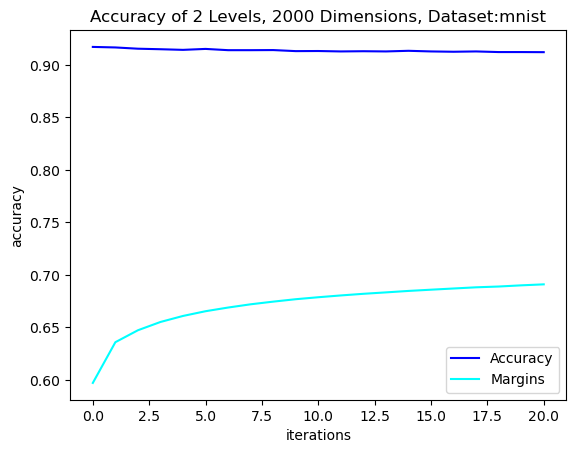

Maximum Accuracy:0.917199969291687
Level: 2  Metric_lr: 0.001  Accuracies: [0.917199969291687, 0.916700005531311, 0.9154999852180481, 0.9149999618530273, 0.9143999814987183, 0.9152999520301819, 0.9140999913215637, 0.9140999913215637, 0.914199948310852, 0.9131999611854553, 0.9132999777793884, 0.9128999710083008, 0.913100004196167, 0.9128999710083008, 0.9134999513626099, 0.9128999710083008, 0.9125999808311462, 0.9128999710083008, 0.9122999906539917, 0.9122999906539917, 0.9121999740600586] Margins: [0.5970460176467896, 0.6358510255813599, 0.6472291946411133, 0.6551206111907959, 0.6608573794364929, 0.665367066860199, 0.6688725352287292, 0.6719610095024109, 0.6744986176490784, 0.6768076419830322, 0.6786921620368958, 0.6804002523422241, 0.6819605231285095, 0.6833098530769348, 0.6846994161605835, 0.6858794689178467, 0.6870228052139282, 0.6881484389305115, 0.6888952255249023, 0.6900214552879333, 0.690968930721283] t: 0.7


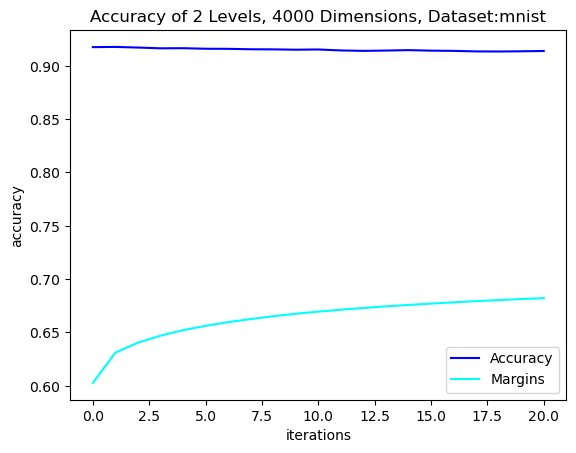

Maximum Accuracy:0.9176999926567078
Level: 2  Metric_lr: 0.001  Accuracies: [0.9174999594688416, 0.9176999926567078, 0.9170999526977539, 0.9163999557495117, 0.9164999723434448, 0.9159999489784241, 0.9158999919891357, 0.9154999852180481, 0.915399968624115, 0.9150999784469604, 0.9152999520301819, 0.9143999814987183, 0.9139999747276306, 0.9142999649047852, 0.9146999716758728, 0.914199948310852, 0.9139999747276306, 0.9134999513626099, 0.9133999943733215, 0.913599967956543, 0.9138999581336975] Margins: [0.6026921272277832, 0.631136417388916, 0.6404486298561096, 0.6469999551773071, 0.6521605253219604, 0.6562181115150452, 0.659660816192627, 0.662574827671051, 0.6652261018753052, 0.6675294637680054, 0.6695550680160522, 0.6713095307350159, 0.6729406714439392, 0.6745108366012573, 0.6757960915565491, 0.6770508885383606, 0.6782544255256653, 0.6793609857559204, 0.6803380846977234, 0.6813580393791199, 0.682202160358429] t: 0.7


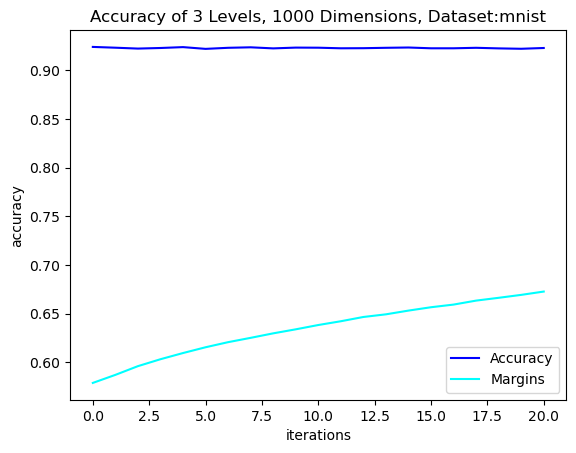

Maximum Accuracy:0.923799991607666
Level: 3  Metric_lr: 0.001  Accuracies: [0.923799991607666, 0.9229999780654907, 0.9220999479293823, 0.9226999878883362, 0.9235999584197998, 0.9217999577522278, 0.9228999614715576, 0.9233999848365784, 0.9222999811172485, 0.9230999946594238, 0.9229999780654907, 0.9223999977111816, 0.92249995470047, 0.9228999614715576, 0.9231999516487122, 0.9223999977111816, 0.9223999977111816, 0.9228999614715576, 0.9222999811172485, 0.9218999743461609, 0.9226999878883362] Margins: [0.5789107084274292, 0.5871726274490356, 0.5961189270019531, 0.6032348275184631, 0.6095775365829468, 0.6155101656913757, 0.6207430362701416, 0.6251780390739441, 0.6297909021377563, 0.6339231729507446, 0.6383434534072876, 0.6422191262245178, 0.646594226360321, 0.6493161916732788, 0.6531487703323364, 0.6565989851951599, 0.6593178510665894, 0.6634036898612976, 0.6662739515304565, 0.6692853569984436, 0.6726943254470825] t: 0.7


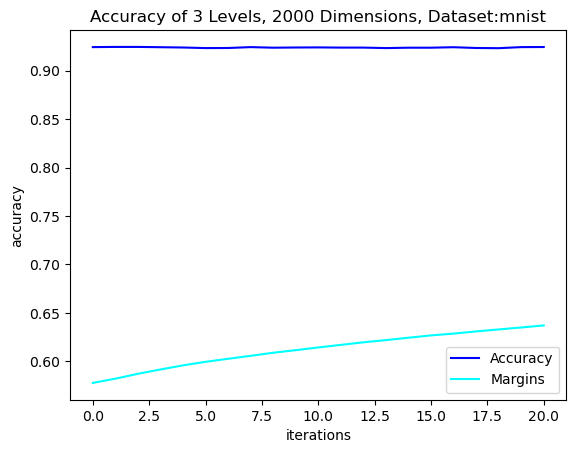

Maximum Accuracy:0.9244999885559082
Level: 3  Metric_lr: 0.001  Accuracies: [0.924299955368042, 0.9244999885559082, 0.9244999885559082, 0.9241999983787537, 0.9238999485969543, 0.9232999682426453, 0.9233999848365784, 0.924299955368042, 0.9236999750137329, 0.9238999485969543, 0.9239999651908875, 0.923799991607666, 0.923799991607666, 0.9232999682426453, 0.9236999750137329, 0.9236999750137329, 0.9241999983787537, 0.9233999848365784, 0.9231999516487122, 0.924299955368042, 0.9243999719619751] Margins: [0.577789843082428, 0.5821674466133118, 0.5872052311897278, 0.5916650891304016, 0.5959351062774658, 0.59954833984375, 0.6026930809020996, 0.6057526469230652, 0.6089381575584412, 0.6115747690200806, 0.6143935918807983, 0.6170420050621033, 0.6196792721748352, 0.6219678521156311, 0.6244322657585144, 0.6268296241760254, 0.6286870241165161, 0.630943238735199, 0.6329847574234009, 0.6349928379058838, 0.6370996832847595] t: 0.7


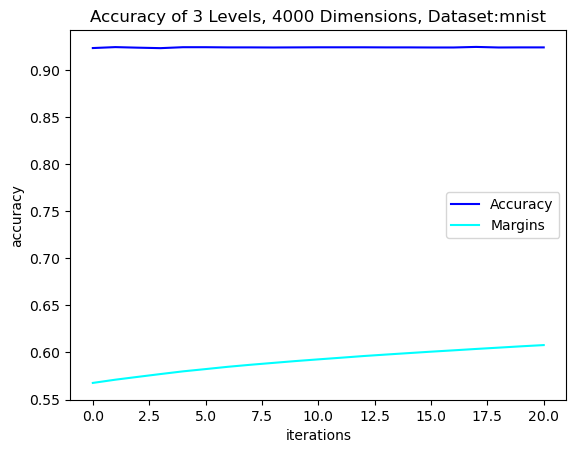

Maximum Accuracy:0.9246000051498413
Level: 3  Metric_lr: 0.001  Accuracies: [0.9233999848365784, 0.9243999719619751, 0.923799991607666, 0.9232999682426453, 0.924299955368042, 0.924299955368042, 0.9240999817848206, 0.9240999817848206, 0.9239999651908875, 0.9240999817848206, 0.9241999983787537, 0.9241999983787537, 0.9241999983787537, 0.9240999817848206, 0.9240999817848206, 0.9239999651908875, 0.9239999651908875, 0.9246000051498413, 0.9239999651908875, 0.9240999817848206, 0.9240999817848206] Margins: [0.567677915096283, 0.5711131691932678, 0.5741288065910339, 0.5770975351333618, 0.5799698233604431, 0.5823699831962585, 0.5848301649093628, 0.5869795083999634, 0.5889541506767273, 0.5909137725830078, 0.5926986932754517, 0.5944381952285767, 0.5962218046188354, 0.5978056192398071, 0.5993466377258301, 0.6008704900741577, 0.6022953987121582, 0.6037625074386597, 0.6051544547080994, 0.6065687537193298, 0.6078731417655945] t: 0.7


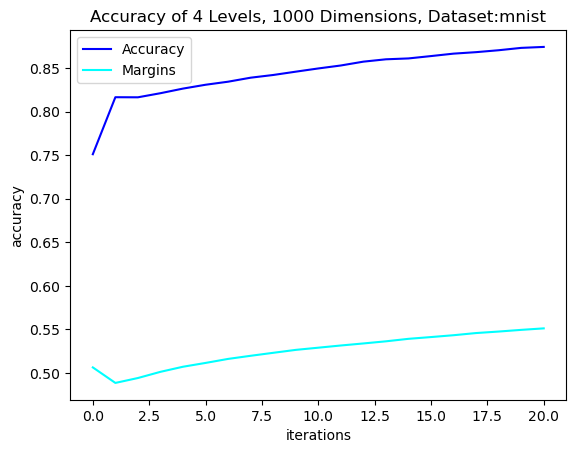

Maximum Accuracy:0.8740999698638916
Level: 4  Metric_lr: 0.001  Accuracies: [0.7509999871253967, 0.8163999915122986, 0.8162999749183655, 0.8209999799728394, 0.8262999653816223, 0.8306999802589417, 0.8341999650001526, 0.8387999534606934, 0.8418999910354614, 0.8456999659538269, 0.849399983882904, 0.8527999520301819, 0.8571999669075012, 0.8598999977111816, 0.8608999848365784, 0.863599956035614, 0.8664000034332275, 0.8680999875068665, 0.8702999949455261, 0.8729999661445618, 0.8740999698638916] Margins: [0.5064403414726257, 0.4886298179626465, 0.4942556917667389, 0.5013584494590759, 0.5071972608566284, 0.5115630030632019, 0.5161734223365784, 0.5197604894638062, 0.5231655836105347, 0.526533305644989, 0.5290481448173523, 0.5315698385238647, 0.5339129567146301, 0.5363582968711853, 0.5392143726348877, 0.5412451028823853, 0.5433545708656311, 0.5458495020866394, 0.5475670099258423, 0.5494900941848755, 0.5512095093727112] t: 0.7


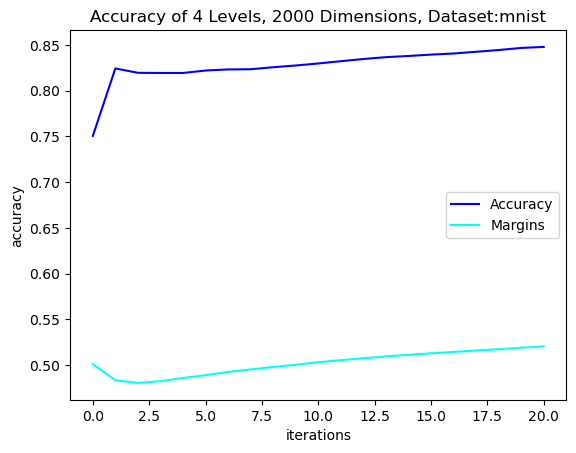

Maximum Accuracy:0.8478999733924866
Level: 4  Metric_lr: 0.001  Accuracies: [0.7505999803543091, 0.824400007724762, 0.819599986076355, 0.8193999528884888, 0.8193999528884888, 0.8220999836921692, 0.8233000040054321, 0.8234999775886536, 0.8256999850273132, 0.8276000022888184, 0.8297999501228333, 0.8323000073432922, 0.8346999883651733, 0.8366999626159668, 0.8379999995231628, 0.8394999504089355, 0.8406999707221985, 0.8425999879837036, 0.8445000052452087, 0.8467999696731567, 0.8478999733924866] Margins: [0.5011314153671265, 0.4836242198944092, 0.480613648891449, 0.4825223386287689, 0.4859201908111572, 0.4891008734703064, 0.49257245659828186, 0.49539095163345337, 0.4980241060256958, 0.5005223751068115, 0.5032228827476501, 0.5054494738578796, 0.5076404809951782, 0.5095828771591187, 0.5113402009010315, 0.5129570364952087, 0.5144964456558228, 0.5160520672798157, 0.5174477696418762, 0.5190681219100952, 0.5205675959587097] t: 0.7


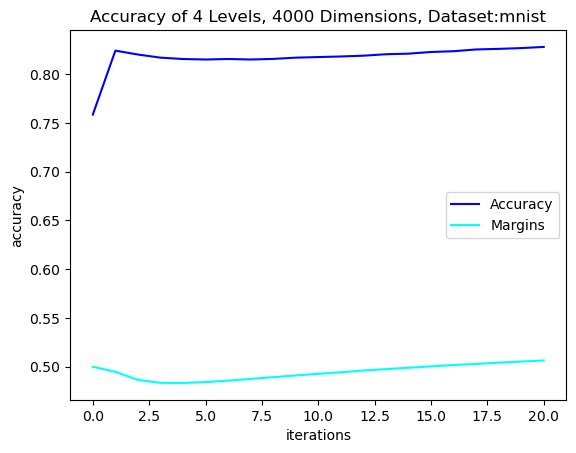

Maximum Accuracy:0.8278999924659729
Level: 4  Metric_lr: 0.001  Accuracies: [0.7584999799728394, 0.8240999579429626, 0.820099949836731, 0.8168999552726746, 0.8154999613761902, 0.8149999976158142, 0.8154999613761902, 0.8149999976158142, 0.8155999779701233, 0.8168999552726746, 0.8174999952316284, 0.8180999755859375, 0.8188999891281128, 0.8203999996185303, 0.8209999799728394, 0.8226999640464783, 0.8234999775886536, 0.8252999782562256, 0.8258999586105347, 0.82669997215271, 0.8278999924659729] Margins: [0.49999114871025085, 0.49480918049812317, 0.48648905754089355, 0.4834693372249603, 0.48337605595588684, 0.4842222034931183, 0.48573943972587585, 0.4875003695487976, 0.4892863631248474, 0.4910287857055664, 0.4927402138710022, 0.494296669960022, 0.49608781933784485, 0.49751609563827515, 0.4989393353462219, 0.5003823637962341, 0.5017241835594177, 0.5028205513954163, 0.5042039155960083, 0.5052655339241028, 0.5063868761062622] t: 0.7


In [2]:
datasets = ["mnist"]
levels = [2,3,4]
metric_lrs = [0.001]
HD_lrs =[1]
accs = {}
margs = {}
dimensions = [1000,2000, 4000]
quant_lrs = [1.0]
ts = [0.7]

plot = False
vis = False

for dataset in datasets:
    for level in levels:
        for HD_lr in HD_lrs:
            for metric_lr in metric_lrs:
                for quant_lr in quant_lrs:
                    for dimension in dimensions:
                        for t in ts:
                            acc, marg = test_quantizer(dataset=dataset,levels = level, D = dimension, quant_lr =quant_lr, t=t,
                            metric_lr = metric_lr ,HD_lr=HD_lr, enc_type="RP", similarity_type = "cosine", plot=plot, visualize=vis)
                            margs[t] = marg
                            accs[t] = acc

In [3]:
import csv

with open('test_Full_10_Metric_20_Quant_t_mnist_2_levels_1000_D.csv', 'w') as output:
    writer = csv.writer(output)
    for key, value in accs.items():
        writer.writerow([key, value])
    
    for key, value in margs.items():
        writer.writerow([key, value])